# Basics of Machine Learning -- A physics-agnostic, curve-fitting approach 


This notebook accompanies the ECE595 Data analytics course taught at Purdue in Fall 2022. These set of examples pertain to the materials of [lecture 12.](https://github.com/alam740/Data-Analytics-Course/blob/master/Lecture-PDFs/ECE%20595%20-%20Lecture%2012.pdf)

Written by Rohan Sheridan (sherida7@purdue.edu)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt


# For the first Neural Net, we will break down every step from setting parameters to getting the final output.

### First we must define our "Hyperparamters"

### Hyperparameters are commonly mentioned in machine learning, and essentially refer to the parameters and settings you tune which control how your model learns.

### In this case of a simple neural net, we only have a few hyperparameters:

* Number of inputs

* Number of Neurons (sometimes refered to as your hidden layer)

* Number of outputs

* Batch size (# of samples used per foward pass [Will explain more later]

* Learning Rate (essentially how aggresively the weights change each epoch)

* And, number of epochs (how long we train our model)

In [ ]:
n_input = 1
n_hidden = 1
n_out = 1
batch_sz = 5
learning_rate = 0.025
epochs = 2500

### Now we will set up our data in a useable form for pytorch.

NOTE: if you are intrested in using pytorch for academic and personal use, I *highly* recomend you read the pytorch documentation on [Datasets & Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

- The way I am using PyTorch's Dataloader class is unconventional and thus not functioning properly. I have worked to massage the pytorch class into being usuable for this toy problem but will most likely not work for other data/uses.


# TLDR: The way I am using the dataloader is bad, but using a dataloader is important.

### So, why is a dataloader important? Mainly, it allows us to define a batch size for training. In the default case of this notebook, we have defined our batch size to be 5. This means for each epoch the model will train with small batches of data untill all the data is trained over. The small batches consisting of 5 data points (with labels) will be plucked out and trained with.

#### we have ~ 20 data points and a batch size of 5, so for *each epoch*, we will train/adjust the model *4 times using 5 datapoints each time*.

This is good practice for training models as it can help with generalizing predictions better (i.e a better fit)



In [ ]:
hrs =     np.asarray([[0.5,0.75,1,1.25,1.5,1.75,1.75,2,2.25,2.5,
          2.75,3,3.25,3.5,4,4.25,4.5,4.75,5,5.5]])

passed =  np.asarray([[0,0,0,0,0,0,1,0,1,0,
           1,0,1,0,1,1,1,1,1,1]])

## We initially define our data and labels as row vectors
## Then we transpose the data, otherwise pytorch doesnt read 
## the data properly
## If the data is a row vector, it is taken as ONE datapoint
## So, we transpose into column vectors

hrs = np.transpose(hrs)
passed = np.transpose(passed)

## Next we convert the np arrays into pytorch tensors
## Pytorch cannot take numpy arrays directly, so we must use this function
x_data = torch.FloatTensor(hrs)
y_data = torch.FloatTensor(passed)

## We make further modifications to our data
## passing it into the TensorDataset function
## This modifies the data to be in a useable form for the Dataloader

dataset = TensorDataset(x_data,y_data)

## Finally, we pass in our dataset into the dataloader
## and define our batch size
## Now the data is ready to use...

dataloader = DataLoader(dataset, batch_size=batch_sz)

Now we define the structure of the model

Becuase this is a fairly straight foward example we can create our neural net using PyTorch's sequential neural net builder. For a more complex NN I would recomend following PyTorch's [documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) on constructing a custom NN Class

For the first example, we have a 1 neuron NN. Our model is sequential and consists of a linear layer feeding into a sigmoidal activation function.

The linear layer takes in the data and applies a linear transformation

$Z_1 = W_1x +b_1 $

Taking in a datapoint x, we multiply by the weight $W_1$ and a bias $b_1$, giving us the output $Z_1$ of our linear layer .

Then we feed this output into a sigmoidal activation layer to get our output

$Y_{pred} = σ(Z_1)$



$Y_{pred} = \frac{1}{1 + e^{Z_1}}$

$Y_{pred} = \frac{1}{1 + e^{W_1x +b_1}}$



In [ ]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid()) 

## Linear Layer Feeds into Sigmoidal activation function

loss_function = nn.MSELoss()  ## We use MSE Loss
                              ## You can try other loss functions

## Next we pass in our model to an optimizer
## The optimizer helps adjust the parameters after each batch

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Model Structure: \n\n", model)

Model Structure: 

 Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)


# Next we train the model

We will iterate through an outer for loop for the amount of epochs we defined

within each epoch we make predictions on a batch of data,
calculate loss, and then update our parameters. This is repeated until we cover all of the data.

At the end of all of our epochs, we have a trained model 

In [ ]:
losses = []

for epoch in range(epochs):

  for data in enumerate(dataloader):
      # Every data instance is an input + label pair
      null, batch = data
      #print(data)

      x = batch[0]
      y = batch[1]

      pred_y = model(x)
      loss = loss_function(pred_y, y)

      model.zero_grad()
      loss.backward()

      optimizer.step()
  
  pred_y = model(x_data)

  loss = loss_function(pred_y, y_data)
  losses.append(loss.item())
  



# We can plot the loss over epochs to see if our model converged 

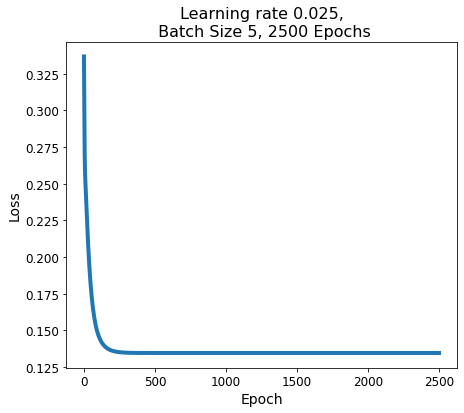

In [ ]:
#@title Plot Loss
print("\n")

plt.figure(1, (7,6))

plt.plot(losses,linewidth=4)
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("Learning rate %0.3f,\n Batch Size %s, %s Epochs"
            %(learning_rate,batch_sz,epochs),fontsize =16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


# We can also plot our models predictions on the data and compare it to the experimental results...

### I've also included a plot of the rounded fit. Sometimes with Sigmoidal activation functions, the desired result is a binary output (i.e Pass or Fail). This can by rounding the output according to some constraint.

*In this case, if the output is less than 0.5, the student is marked as Failing. Otherwise the student is marked as Passing.*

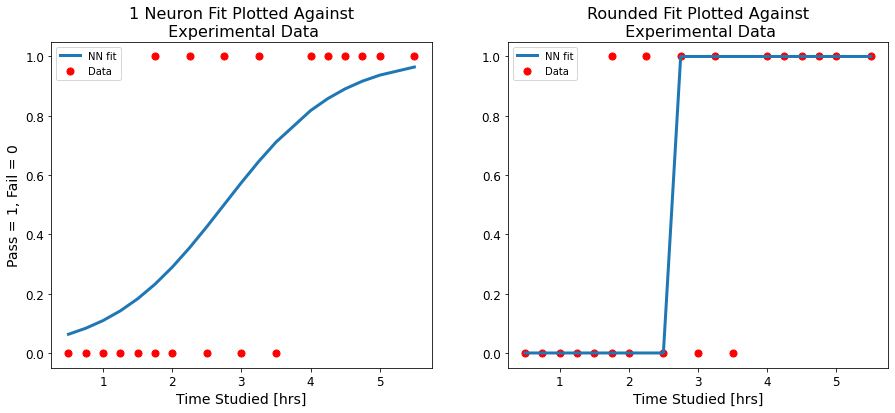

In [ ]:
#@title Plot Results

plt.figure(2, (15,6))

plt.subplot(1,2,1)
y = model(x_data).detach()

plt.plot(x_data,y,linewidth=3)
plt.scatter(x_data,y_data,c='r',s=50)

plt.ylabel('Pass = 1, Fail = 0',fontsize=14)
plt.xlabel('Time Studied [hrs]',fontsize=14)
plt.legend(["NN fit","Data"])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title("1 Neuron Fit Plotted Against\n Experimental Data",
          fontsize = 16)

yproc = []

for i in y:
  if i<0.5: yproc.append(0)
  else:
    yproc.append(1)

plt.subplot(1,2,2)

plt.plot(x_data,yproc,linewidth=3)
plt.scatter(x_data,y_data,c='r',s=50)

plt.xlabel('Time Studied [hrs]',fontsize=14)
plt.legend(["NN fit","Data"])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title("Rounded Fit Plotted Against\n Experimental Data",
          fontsize = 16)


plt.show()

# Now we add another neuron by changing the n_hidden to 2 and then we repeat the process again.

In [ ]:
n_input = 1
n_hidden = 2
n_out = 1
batch_sz = 1
learning_rate = 0.025
epochs = 2000

hrs =     np.asarray([[0.5,0.75,1,1.25,1.5,1.75,1.75,2,2.25,2.5,
          2.75,3,3.25,3.5,4,4.25,4.5,4.75,5,5.5,5.75,
          6.0,6.25,6.5,6.75,7.0]])

passed =  np.asarray([[0,0,0,0,0,0,1,0,1,0,
           1,0,1,0,1,1,1,1,1,1,0,
           1,0,0,0,0]])


hrs = np.transpose(hrs)
passed = np.transpose(passed)

x_data = torch.FloatTensor(hrs)
y_data = torch.FloatTensor(passed)

dataset = TensorDataset(x_data,y_data)

dataloader = DataLoader(dataset, batch_size=batch_sz)

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden,n_out),
                      )
print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


losses = []


for epoch in range(epochs):

  for data in enumerate(dataloader):
      null, batch = data

      x = batch[0]
      y = batch[1]

      pred_y = model(x)
      loss = loss_function(pred_y, y)

      model.zero_grad()
      loss.backward()

      optimizer.step()
  
  pred_y = model(x_data)

  loss = loss_function(pred_y, y_data)
  losses.append(loss.item())
  


Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


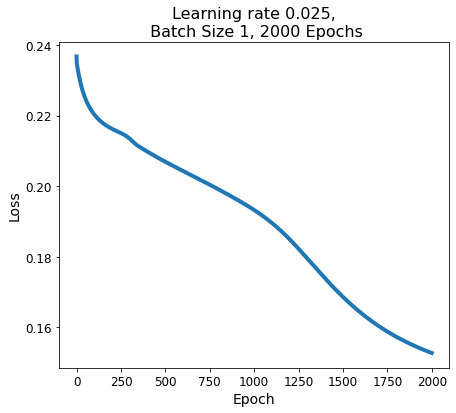

In [ ]:
#@title Plot Loss

print("\n")

plt.figure(3, (7,6))

plt.plot(losses,linewidth=4)
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("Learning rate %0.3f,\n Batch Size %s, %s Epochs"
            %(learning_rate,batch_sz,epochs),fontsize =16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()



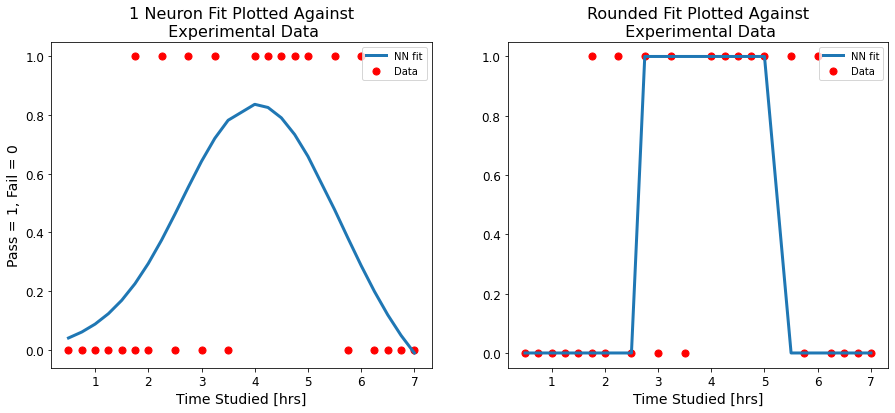

In [ ]:
#@title Plot Result
plt.figure(4, (15,6))

plt.subplot(1,2,1)
y = model(x_data).detach()

plt.plot(x_data,y,linewidth=3)
plt.scatter(x_data,y_data,c='r',s=50)

plt.ylabel('Pass = 1, Fail = 0',fontsize=14)
plt.xlabel('Time Studied [hrs]',fontsize=14)
plt.legend(["NN fit","Data"])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title("1 Neuron Fit Plotted Against\n Experimental Data",
          fontsize = 16)


yproc = []

for i in y:
  if i<0.5: yproc.append(0)
  else:
    yproc.append(1)

plt.subplot(1,2,2)

plt.plot(x_data,yproc,linewidth=3)
plt.scatter(x_data,y_data,c='r',s=50)

plt.xlabel('Time Studied [hrs]',fontsize=14)
plt.legend(["NN fit","Data"])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title("Rounded Fit Plotted Against\n Experimental Data",
          fontsize = 16)


plt.show()

Adopted from:

https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d
